# HB vs MLE Recovery (Within-Subjects)

This notebook compares hierarchical Bayesian (HB) within-subjects HMeta-d and
MLE recovery of the **mean Mratio difference** between two conditions. The
setup is inspired by Figure 5A in Fleming (2017), but we focus on a **paired
condition difference** rather than a null test against 1.

We simulate datasets with a known ground-truth difference between conditions
and vary the number of trials per condition to see how each method recovers
that mean difference.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

import metadpy
from metadpy.bayesian import hmetad
from metadpy.mle import metad
from metadpy.utils import pairedResponseSimulation


In [2]:
print('metadpy version:', metadpy.__version__)


metadpy version: 0.1.1


## Simulation settings

- Two conditions: **easy** (higher Mratio) and **hard** (lower Mratio)
- Ground truth difference: `mratio_hard - mratio_easy`
- We vary trial counts per condition


In [3]:
n_subjects = 20
n_ratings = 4

mratio_easy = 1.2
mratio_hard = 0.7
true_delta = mratio_hard - mratio_easy

trial_counts = [50, 100, 200]
n_repeats = 3

# HB sampling (kept small for runtime in a notebook)
hb_draws = 150
hb_tune = 150
hb_chains = 1
hb_target_accept = 0.9

print('True delta (hard - easy):', true_delta)


True delta (hard - easy): -0.5


## Helper functions

We simulate paired conditions with `pairedResponseSimulation`, then estimate
mean Mratio difference with:
- MLE: fit per subject/condition using `metad`, then average the differences
- HB: fit the repeated-measures model and compute the posterior mean of the
  group-level Mratio difference


In [4]:
def simulate_dataset(seed, n_trials):
    np.random.seed(seed)
    df = pairedResponseSimulation(
        d=1.5,
        d_sigma=0.2,
        mRatio=[mratio_easy, mratio_hard],
        mRatio_sigma=0.2,
        mRatio_rho=0.4,
        c=0.0,
        c_sigma=0.1,
        nRatings=n_ratings,
        nTrials=n_trials,
        nSubjects=n_subjects,
    )
    df['Condition'] = df['Condition'].map({0: 'easy', 1: 'hard'})
    return df


def estimate_mle_delta(df):
    res = metad(
        data=df,
        nRatings=n_ratings,
        stimuli='Stimuli',
        accuracy='Accuracy',
        confidence='Confidence',
        subject='Subject',
        within='Condition',
        padding=True,
        verbose=0,
    )
    pivot = res.pivot(index='Subject', columns='Condition', values='m_ratio')
    delta = pivot['hard'] - pivot['easy']
    return float(delta.mean())


def estimate_hb_delta(df, seed):
    model, _ = hmetad(
        data=df,
        nRatings=n_ratings,
        stimuli='Stimuli',
        accuracy='Accuracy',
        confidence='Confidence',
        subject='Subject',
        within='Condition',
        sample_model=False,
    )
    with model:
        idata = pm.sample(
            draws=hb_draws,
            tune=hb_tune,
            chains=hb_chains,
            target_accept=hb_target_accept,
            random_seed=seed,
            progressbar=False,
            return_inferencedata=True,
        )

    meta_d = idata.posterior['meta_d']
    d1 = idata.posterior['d1']

    dims = {dim: size for dim, size in meta_d.sizes.items() if dim not in ('chain', 'draw')}
    subj_dim = max(dims, key=dims.get)
    cond_dim = min(dims, key=dims.get)

    m_ratio = (meta_d / d1).assign_coords({cond_dim: ['easy', 'hard']})
    m_ratio_mean = m_ratio.mean(dim=subj_dim)

    delta = (m_ratio_mean.sel({cond_dim: 'hard'}) - m_ratio_mean.sel({cond_dim: 'easy'}))
    delta_vals = np.asarray(delta.values).reshape(-1)
    return float(delta_vals.mean())


## Recovery loop

We run small Monte Carlo loops per trial count and compare the recovered
mean differences against the ground truth.


In [5]:
records = []
base_seed = 123

for n_trials in trial_counts:
    for rep in range(n_repeats):
        seed = base_seed + n_trials * 100 + rep
        df = simulate_dataset(seed=seed, n_trials=n_trials)

        mle_delta = estimate_mle_delta(df)
        hb_delta = estimate_hb_delta(df, seed=seed + 999)

        records.append({'n_trials': n_trials, 'method': 'MLE', 'delta': mle_delta})
        records.append({'n_trials': n_trials, 'method': 'HB', 'delta': hb_delta})

results = pd.DataFrame(records)
results.head()


Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_d1, sigma_d1, d1, mu_c1, sigma_c1, c1, mu_meta_d, sigma_meta_d, condition_offset_raw, meta_d, cS1_hn, cS2_hn]
Sampling 1 chain for 150 tune and 150 draw iterations (150 + 150 draws total) took 32 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_d1, sigma_d1, d1, mu_c1, sigma_c1, c1, mu_meta_d, sigma_meta_d, condition_offset_raw, meta_d, cS1_hn, cS2_hn]
Sampling 1 chain for 150 tune and 150 draw iterations (150 + 150 draws total) took 47 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sa

,n_trials,method,delta
0,50,MLE,-0.448586
1,50,HB,-0.461417
2,50,MLE,-0.381491
3,50,HB,-0.490228
4,50,MLE,-0.337847


In [6]:
summary = (
    results.groupby(['n_trials', 'method'])['delta']
    .agg(
        mean='mean',
        low=lambda x: np.quantile(x, 0.03),
        high=lambda x: np.quantile(x, 0.97),
    )
    .reset_index()
)
summary['bias'] = summary['mean'] - true_delta
summary


,n_trials,method,mean,low,high,bias
0,50,HB,-0.424026,-0.488499,-0.328893,0.075974
1,50,MLE,-0.389308,-0.444560,-0.340465,0.110692
2,100,HB,-0.509533,-0.580298,-0.412163,-0.009533
3,100,MLE,-0.502028,-0.556421,-0.439749,-0.002028
4,200,HB,-0.497680,-0.531563,-0.447441,0.002320
5,200,MLE,-0.519138,-0.537582,-0.505364,-0.019138


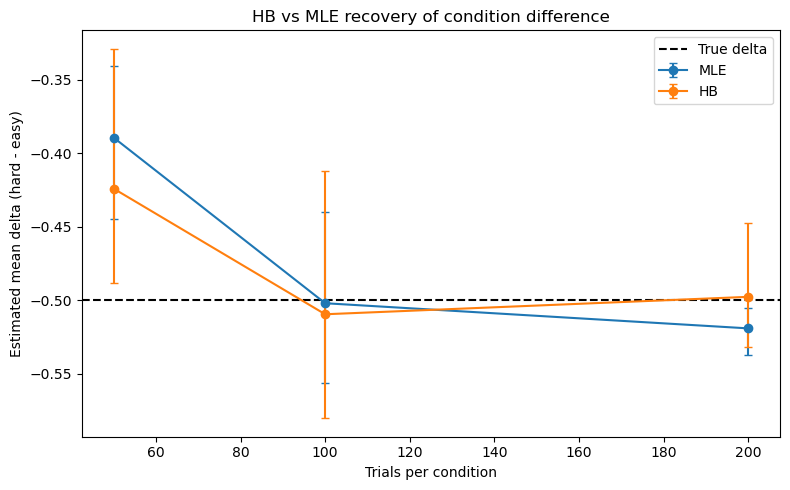

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

for method in ['MLE', 'HB']:
    sub = summary[summary['method'] == method]
    yerr = np.vstack([sub['mean'] - sub['low'], sub['high'] - sub['mean']])
    ax.errorbar(
        sub['n_trials'],
        sub['mean'],
        yerr=yerr,
        marker='o',
        capsize=3,
        label=method,
    )

ax.axhline(true_delta, color='k', linestyle='--', label='True delta')
ax.set_xlabel('Trials per condition')
ax.set_ylabel('Estimated mean delta (hard - easy)')
ax.set_title('HB vs MLE recovery of condition difference')
ax.legend()
plt.tight_layout()


## Notes

- This is a small Monte Carlo demo for speed. Increase `n_repeats`,
  `hb_draws`, and `hb_tune` for a more stable comparison.
- The HB approach uses a hierarchical model and returns a posterior mean
  for the condition difference. The MLE approach averages subject-level
  differences with no pooling.
